In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
buildings = gpd.read_parquet("/data/uscuni-ulce/boundaries_of_change/classification/")

In [3]:
gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg")

,name,geometry_type
0,1240_mongol_invasion,Polygon
1,900_political,Polygon
2,1000_political,Polygon
3,1300_ostsiedlung,Polygon
4,1550_religion,Polygon
5,1526_political,Polygon
6,1618_political,Polygon
7,1648_political,Polygon
8,1600_religion,Polygon
9,1812_political,Polygon


In [4]:
boundaries = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
boundaries= boundaries[boundaries.NAME != "Hungary"]

In [5]:
buildings.head()

,geometry,final_without_noise,area
__null_dask_index__,,,
0,POINT (4099683.344 3108236.287),50,66.767646
1,POINT (4100189.13 3108803.392),1,427.019080
2,POINT (4100069.189 3109146.3),1,144.324859
3,POINT (4100144.944 3108299.666),1,139.581363
4,POINT (4100022.946 3108688.179),1,41.651016


In [6]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v3.pq"
)
final_clusters

,1,2,3,4,5,6
7,,,,,,
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,2
4,1,1,1,1,1,2
5,1,1,1,1,2,3
...,...,...,...,...,...,...
104,2,4,8,16,31,59
105,2,4,8,16,31,59
106,2,4,8,16,32,60


In [7]:
level_columns = []

In [8]:
for level in final_clusters.columns:
    buildings[f"level_{level}"] = buildings.final_without_noise.map(
        final_clusters[level]
    )
    level_columns.append(f"level_{level}")

In [9]:
buildings.head()

,geometry,final_without_noise,area,level_1,level_2,level_3,level_4,level_5,level_6
__null_dask_index__,,,,,,,,,
0,POINT (4099683.344 3108236.287),50,66.767646,1,2,4,8,16,30
1,POINT (4100189.13 3108803.392),1,427.019080,1,1,1,1,1,1
2,POINT (4100069.189 3109146.3),1,144.324859,1,1,1,1,1,1
3,POINT (4100144.944 3108299.666),1,139.581363,1,1,1,1,1,1
4,POINT (4100022.946 3108688.179),1,41.651016,1,1,1,1,1,1


In [10]:
boundaries.explore()

In [11]:
boundaries.head()

,NAME,NOTES,geometry
0,Austria,None,"MULTIPOLYGON (((4355225.354 2715902.995, 43542..."
1,Czechia,None,"MULTIPOLYGON (((4623550.104 3113763.447, 46305..."
2,Germany,None,"MULTIPOLYGON (((4355225.354 2715902.995, 43557..."
3,Poland,None,"MULTIPOLYGON (((4922206.626 3502100.945, 49317..."
4,Slovakia,None,"MULTIPOLYGON (((5029148.516 2968082.296, 50325..."


In [12]:
joined = gpd.sjoin(buildings, boundaries, how="left", predicate="within")
joined.head()

,geometry,final_without_noise,area,level_1,level_2,level_3,level_4,level_5,level_6,index_right,NAME,NOTES
__null_dask_index__,,,,,,,,,,,,
0,POINT (4099683.344 3108236.287),50,66.767646,1,2,4,8,16,30,2.0,Germany,None
1,POINT (4100189.13 3108803.392),1,427.019080,1,1,1,1,1,1,2.0,Germany,None
2,POINT (4100069.189 3109146.3),1,144.324859,1,1,1,1,1,1,2.0,Germany,None
3,POINT (4100144.944 3108299.666),1,139.581363,1,1,1,1,1,1,2.0,Germany,None
4,POINT (4100022.946 3108688.179),1,41.651016,1,1,1,1,1,1,2.0,Germany,None


In [13]:
grouped = joined.groupby("NAME")["level_4"].value_counts()

In [14]:
cnt_table = pd.DataFrame(grouped.unstack().fillna(0).T)
cnt_table = cnt_table.drop([3,4,10])
cnt_table

NAME,Austria,Czechia,Germany,Poland,Slovakia
level_4,,,,,
1,295882.0,666690.0,9671999.0,600894.0,196889.0
2,97407.0,52089.0,1022896.0,41404.0,18937.0
5,526396.0,446937.0,3060254.0,1457583.0,408064.0
6,58910.0,36615.0,10672596.0,117546.0,279875.0
7,519449.0,265055.0,6871006.0,421834.0,588545.0
8,409896.0,280692.0,10716531.0,553595.0,771685.0
9,176053.0,121746.0,108096.0,2822365.0,56750.0
11,363.0,3255.0,50014.0,742410.0,52474.0
12,9744.0,35316.0,432550.0,1801896.0,233460.0


In [15]:
region_building_sums = cnt_table.sum(axis=0)
cnt_table_norm = cnt_table.div(region_building_sums, axis=1)
cnt_table_norm.sum()

NAME
Austria     1.0
Czechia     1.0
Germany     1.0
Poland      1.0
Slovakia    1.0
dtype: float64

In [16]:
import scipy.stats as stats
from scipy.spatial import distance
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Bray-Curtis

In [17]:
cnt_table_norm.iloc[:,0]

level_4
1     0.067609
2     0.022257
5     0.120281
6     0.013461
7     0.118694
8     0.093661
9     0.040228
11    0.000083
12    0.002227
13    0.443387
14    0.057529
15    0.014902
16    0.005681
Name: Austria, dtype: float64

In [18]:
num_regions = len(cnt_table_norm.columns)

In [19]:
bray_curtis_matrix = np.zeros((num_regions, num_regions))

In [20]:
for i in range(num_regions):
    for j in range(num_regions):
        if i != j:
            reg_i = cnt_table_norm.iloc[:,i]
            reg_j = cnt_table_norm.iloc[:,j]
            bray_curtis_matrix[i,j] = distance.braycurtis(reg_i, reg_j)

In [21]:
bray_curtis_matrix

array([[0.        , 0.12874391, 0.50267606, 0.40361692, 0.483206  ],
       [0.12874391, 0.        , 0.50561394, 0.40187741, 0.57390556],
       [0.50267606, 0.50561394, 0.        , 0.65469059, 0.30571382],
       [0.40361692, 0.40187741, 0.65469059, 0.        , 0.51771699],
       [0.483206  , 0.57390556, 0.30571382, 0.51771699, 0.        ]])

In [22]:
bray_curtis_matrix = pd.DataFrame(bray_curtis_matrix, index=cnt_table_norm.columns, columns=cnt_table_norm.columns)
bray_curtis_matrix

NAME,Austria,Czechia,Germany,Poland,Slovakia
NAME,,,,,
Austria,0.000000,0.128744,0.502676,0.403617,0.483206
Czechia,0.128744,0.000000,0.505614,0.401877,0.573906
Germany,0.502676,0.505614,0.000000,0.654691,0.305714
Poland,0.403617,0.401877,0.654691,0.000000,0.517717
Slovakia,0.483206,0.573906,0.305714,0.517717,0.000000


<Axes: xlabel='NAME', ylabel='NAME'>

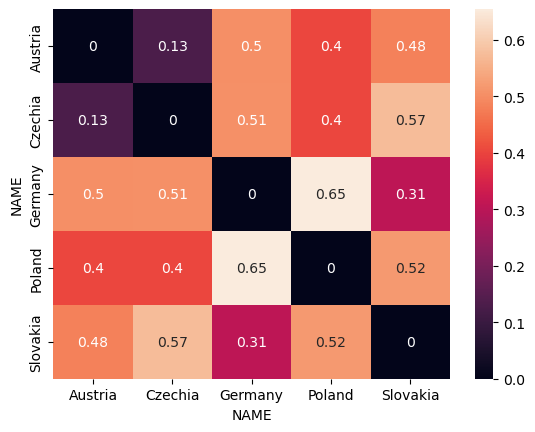

In [23]:
sns.heatmap(bray_curtis_matrix, annot=True)

## Principal Coordinates visualization

In [30]:
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DistanceMatrix

In [31]:
pcoa_res = pcoa(DistanceMatrix(bray_curtis_matrix, ids=cnt_table_norm.columns))

/home/danka/work/boundaries_of_change/.pixi/envs/default/lib/python3.13/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.010800759713811448 whereas the largest positive one is 0.2838026865911484.
  warn(


In [32]:
pcoa_res_df = pd.DataFrame(pcoa_res.samples.iloc[:, :2], index=cnt_table_norm.columns)

In [33]:
pcoa_res_df

,PC1,PC2
NAME,,
Austria,-0.146522,-0.114453
Czechia,-0.194218,-0.171311
Germany,0.316862,-0.111141
Poland,-0.236985,0.237750
Slovakia,0.260863,0.159156


<Axes: xlabel='PC1', ylabel='PC2'>

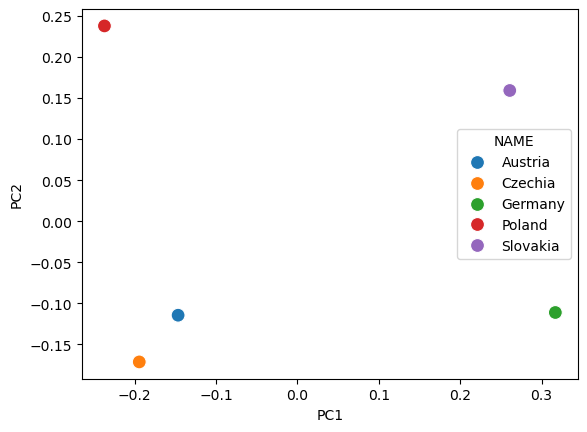

In [34]:
sns.scatterplot(x="PC1", y="PC2", hue=pcoa_res_df.index, data=pcoa_res_df, s=100)

In [35]:
pcoa_res.proportion_explained

PC1    0.628915
PC2    0.302831
PC3    0.068253
PC4    0.000000
PC5    0.000000
dtype: float64